<a href="https://colab.research.google.com/github/Nickcys/hw3_M11221055/blob/main/U_net%2B%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# UNet++ 整合實驗程式（專案架構版）

import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from segmentation_models_pytorch import UnetPlusPlus

In [ ]:
# ========== 損失函數：Dice + BCE ==========
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.smooth = smooth

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return bce_loss + dice_loss
# ========== Dataset 類別 ==========
class ETTDataset(Dataset):
    def __init__(self, img_dir, mask_dir, size=(256, 256), augment=False):
        self.img_list = sorted(os.listdir(img_dir))
        self.mask_list = sorted(os.listdir(mask_dir))
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.size = size
        self.augment = augment
        self.to_tensor = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.augment:
            if random.random() > 0.5:
                img = cv2.flip(img, 1)
                mask = cv2.flip(mask, 1)
            if random.random() > 0.5:
                angle = random.uniform(-5, 5)
                M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), angle, 1.0)
                img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
                mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]), flags=cv2.INTER_NEAREST)

        mask = mask / 255.0
        return self.to_tensor(img), self.to_tensor(mask.astype(np.float32))

In [ ]:
# ========== IOU 與端點誤差工具 ==========
def calc_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * target).sum()
    union = ((pred_bin + target) > 0).float().sum()
    return (intersection / union).item() if union != 0 else 1.0

def evaluate_model_iou(model, dataset, device, name="資料集"):
    model.eval()
    ious = []
    with torch.no_grad():
        for i in range(len(dataset)):
            x, y = dataset[i]
            x = x.unsqueeze(0).to(device)
            pred = torch.sigmoid(model(x)).cpu().squeeze(0)  # ✅ 加 sigmoid
            iou = calc_iou(pred, y)
            ious.append(iou)
    mean_iou = sum(ious) / len(ious)
    print(f"{name} IOU 平均值：{mean_iou:.4f}")


def extract_endpoint_y(mask_tensor):
    mask_bin = (mask_tensor > 0.5).float()
    y_coords = torch.nonzero(mask_bin.squeeze(), as_tuple=False)
    if y_coords.numel() == 0:
        return -1
    return y_coords[:, 0].max().item()

def compute_point_error_metrics(Y_pred_list, Y_true_list, pixel_per_cm=72):
    errors_cm = [abs(p - t) / pixel_per_cm for p, t in zip(Y_pred_list, Y_true_list)]
    mean_error = sum(errors_cm) / len(errors_cm)
    acc_05 = sum(e <= 0.5 for e in errors_cm) / len(errors_cm) * 100
    acc_10 = sum(e <= 1.0 for e in errors_cm) / len(errors_cm) * 100
    print("\n端點誤差評估：")
    print(f"平均誤差：{mean_error:.4f} 公分")
    print(f"≤0.5cm 準確率：{acc_05:.2f}%")
    print(f"≤1.0cm 準確率：{acc_10:.2f}%")

def evaluate_model_endpoint_prediction(model, dataset, device):
    model.eval()
    Y_pred_list, Y_true_list = [], []
    for i in range(len(dataset)):
        x, y = dataset[i]
        x = x.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x).cpu().squeeze(0)
        y_pred = extract_endpoint_y(pred)
        y_true = extract_endpoint_y(y)
        if y_pred != -1 and y_true != -1:
            Y_pred_list.append(y_pred)
            Y_true_list.append(y_true)
    return compute_point_error_metrics(Y_pred_list, Y_true_list)

In [ ]:
# ========== 視覺化工具 ==========
def get_endpoint(mask_bin):
    coords = np.argwhere(mask_bin > 0)
    if coords.size == 0:
        return None
    y = coords[:, 0].max()
    x = coords[coords[:, 0] == y][:, 1].mean()
    return int(x), int(y)
def visualize_prediction(image_tensor, true_mask_tensor, pred_mask_tensor, threshold=0.5):
    img = image_tensor.squeeze().cpu().numpy()
    true_mask = true_mask_tensor.squeeze().cpu().numpy()
    pred_mask = pred_mask_tensor.squeeze().cpu().numpy()
    pred_mask_bin = (pred_mask > threshold).astype(float)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='viridis')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_bin, cmap='plasma')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
def visualize_with_endpoints(image_tensor, true_mask_tensor, pred_mask_tensor, threshold=0.5):
    img = image_tensor.squeeze().cpu().numpy()
    true_mask = true_mask_tensor.squeeze().cpu().numpy()
    pred_mask = pred_mask_tensor.squeeze().cpu().numpy()
    true_bin = (true_mask > 0.5).astype(float)
    pred_bin = (pred_mask > threshold).astype(float)
    gt_point = get_endpoint(true_bin)
    pred_point = get_endpoint(pred_bin)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_bin, cmap='viridis')
    if gt_point:
        plt.scatter(*gt_point, c='red', s=40)
        plt.text(gt_point[0]+2, gt_point[1], "G", color='red', fontsize=12)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_bin, cmap='plasma')
    if pred_point:
        plt.scatter(*pred_point, c='red', s=40)
        plt.text(pred_point[0]+2, pred_point[1], "Y", color='red', fontsize=12)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# ===== 訓練設定 =====
def train_model(model, train_loader, val_loader, device, epochs=30, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = DiceBCELoss()
    best_val_iou = 0
    best_model_path = "best_unetpp.pth"
    wait = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        ious = []
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                pred_val = model(x_val)
                for i in range(len(x_val)):
                    iou = calc_iou(torch.sigmoid(pred_val[i]).cpu(), y_val[i].cpu())
                    ious.append(iou)
        val_iou = sum(ious) / len(ious)

        print(f"[Epoch {epoch+1}/{epochs}] Loss: {total_loss / len(train_loader):.4f}  Val IOU: {val_iou:.4f}")

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), best_model_path)
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}.")
                break

    print("\n✅ 訓練完成，最佳模型已儲存。")
    return best_model_path

In [ ]:
#========== 主程式區 ==========
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset = ETTDataset("./Fold1/train", "./Fold1/trainannot", augment=True)
    val_dataset = ETTDataset("./Fold1/val", "./Fold1/valannot", augment=False)
    test_dataset = ETTDataset("./Fold1/test", "./Fold1/testannot", augment=False)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    model = UnetPlusPlus(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ).to(device)

best_model_path = train_model(model, train_loader, val_loader, device, epochs=30, patience=10)

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

print("\n🎯 測試集結果：")
evaluate_model_endpoint_prediction(model, test_dataset, device)

# === 測試集 IOU 評估 ===
print("\n📐 測試集 IOU：")
evaluate_model_iou(model, test_dataset, device, name="測試集")

[Epoch 1/30] Loss: 0.8759  Val IOU: 0.3337
[Epoch 2/30] Loss: 0.3711  Val IOU: 0.3073
[Epoch 3/30] Loss: 0.3111  Val IOU: 0.4101
[Epoch 4/30] Loss: 0.2520  Val IOU: 0.4458
[Epoch 5/30] Loss: 0.2201  Val IOU: 0.5303
[Epoch 6/30] Loss: 0.2227  Val IOU: 0.5088
[Epoch 7/30] Loss: 0.2016  Val IOU: 0.6011
[Epoch 8/30] Loss: 0.1940  Val IOU: 0.5075
[Epoch 9/30] Loss: 0.1811  Val IOU: 0.5725
[Epoch 10/30] Loss: 0.1749  Val IOU: 0.4343
[Epoch 11/30] Loss: 0.1709  Val IOU: 0.5203
[Epoch 12/30] Loss: 0.1637  Val IOU: 0.5996
[Epoch 13/30] Loss: 0.1492  Val IOU: 0.6004
[Epoch 14/30] Loss: 0.1484  Val IOU: 0.1291
[Epoch 15/30] Loss: 0.1611  Val IOU: 0.3637
[Epoch 16/30] Loss: 0.1430  Val IOU: 0.5212
[Epoch 17/30] Loss: 0.1658  Val IOU: 0.5962

⏹️ Early stopping triggered at epoch 17.

✅ 訓練完成，最佳模型已儲存。

🎯 測試集結果：


C:\Users\邱敬堯\AppData\Local\Temp\ipykernel_3872\1028635806.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location


端點誤差評估：
平均誤差：0.1150 公分
≤0.5cm 準確率：97.87%
≤1.0cm 準確率：100.00%

📐 測試集 IOU：
測試集 IOU 平均值：0.6279


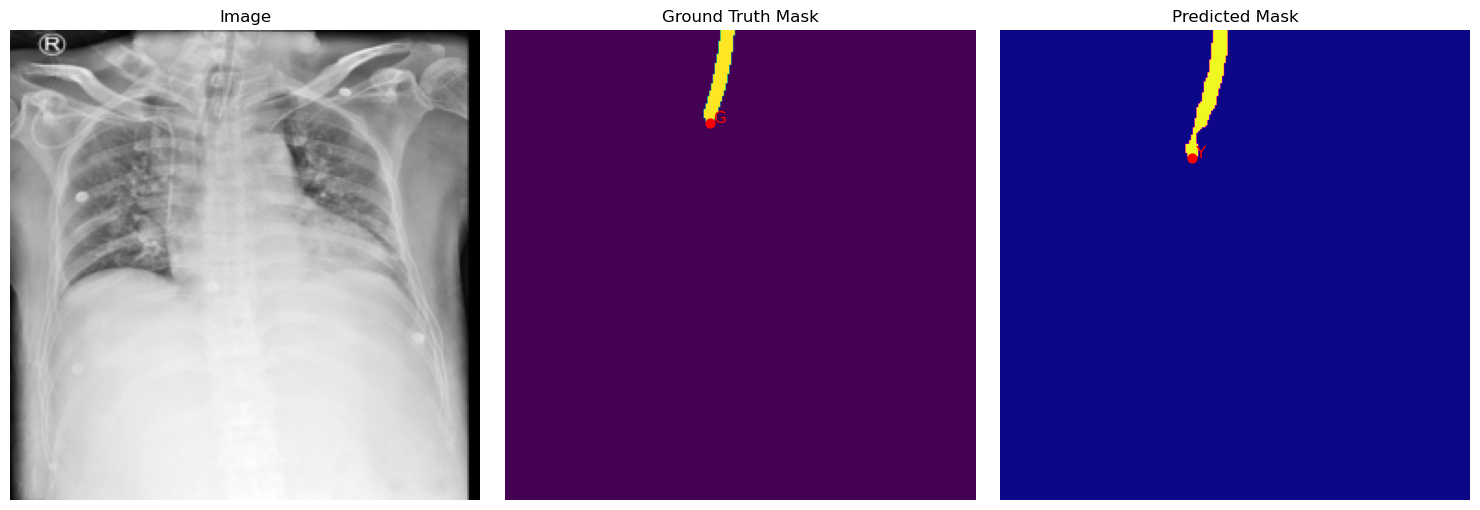

In [ ]:
# === 視覺化幾張測試影像 (test)
for i in [7, 5, 12]:
    x, y = test_dataset[i]
    with torch.no_grad():
        pred = torch.sigmoid(model(x.unsqueeze(0).to(device))).cpu()
visualize_with_endpoints(x, y, pred[0])

train數據


📐 訓練集 IOU：
訓練集 IOU 平均值：0.6343

端點誤差評估：
平均誤差：0.0866 公分
≤0.5cm 準確率：100.00%
≤1.0cm 準確率：100.00%

📸 視覺化訓練資料 #69


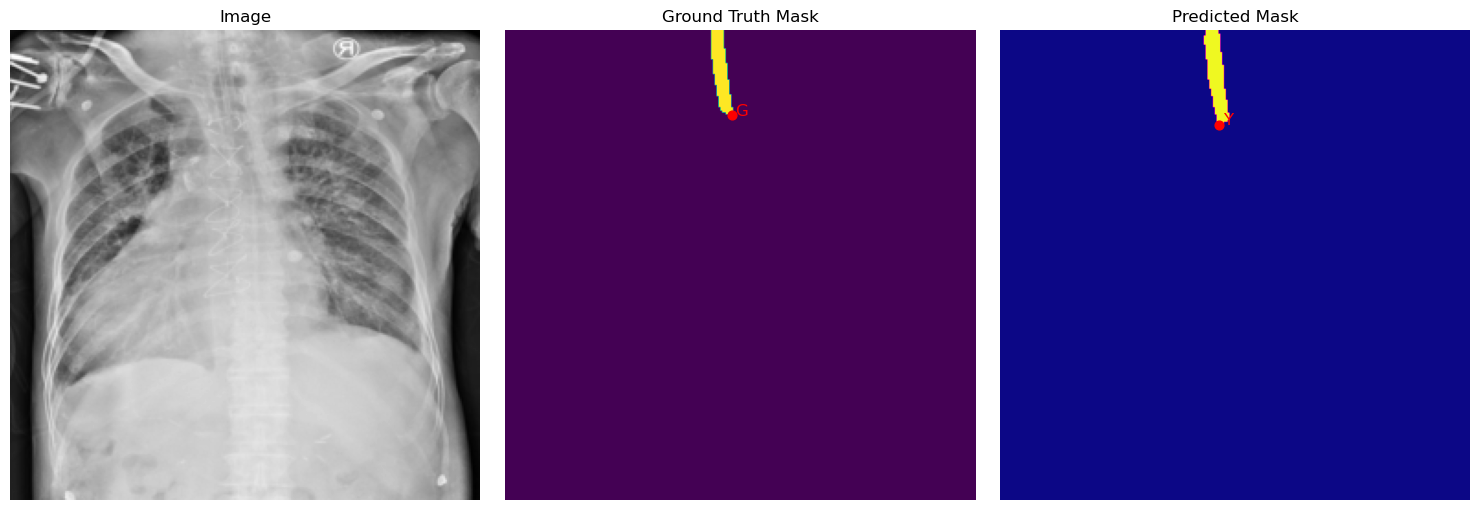

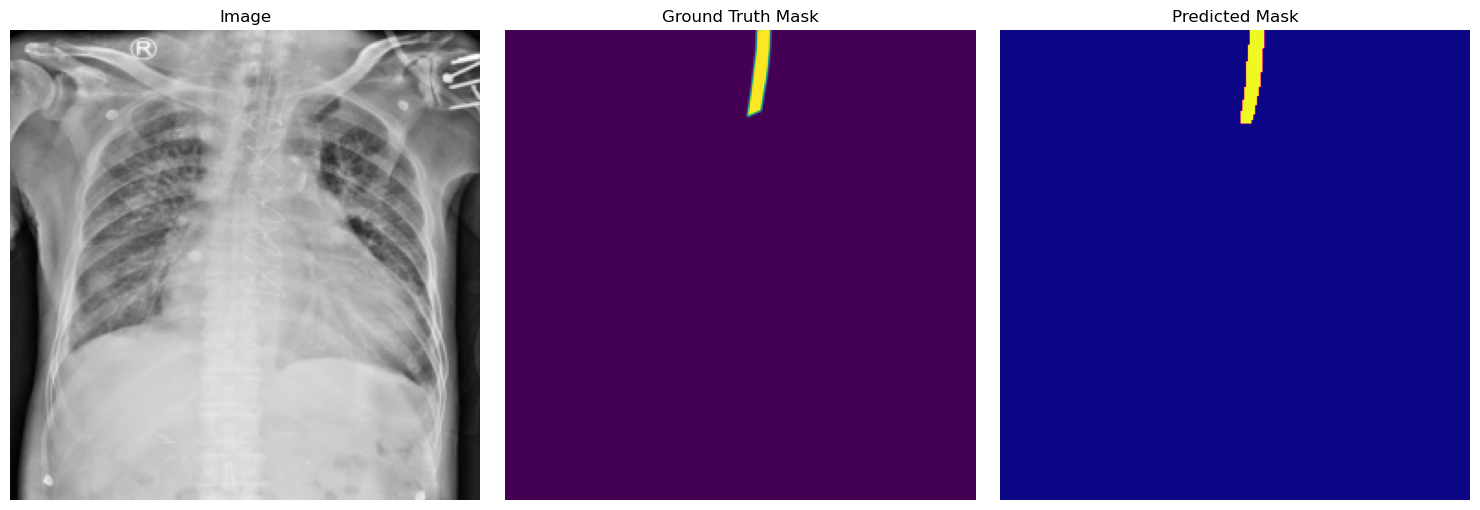

In [ ]:
# 輸出：訓練集 IOU 與數張視覺化(train)
print("\n📐 訓練集 IOU：")
evaluate_model_iou(model, train_dataset, device, name="訓練集")
evaluate_model_endpoint_prediction(model, train_dataset, device)

print("\n📸 視覺化訓練資料 #69")
idx = 69
x, y = train_dataset[idx]
x_input = x.unsqueeze(0).to(device)
with torch.no_grad():
    pred = torch.sigmoid(model(x_input)).cpu()[0]
visualize_with_endpoints(x, y, pred)

model.eval()
with torch.no_grad():
    x, y = train_dataset[69]
    pred = torch.sigmoid(model(x.unsqueeze(0).to(device))).cpu()
visualize_prediction(x, y, pred[0])